In [5]:
#Librerias usadas en la prueba
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
from matplotlib import pyplot
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Cargar Dataset de Energia con una resolución de media hora
energy=pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/energy1.csv')


In [6]:
#energy = pd.read_csv('energy.csv')
len(energy)

169039691

In [7]:
#Dataset del consumo energetico de todas las casas que registra el dataset households Londres Dataset 7GB
energy.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00.0000000,0
1,MAC000002,2012-10-12 01:00:00.0000000,0
2,MAC000002,2012-10-12 01:30:00.0000000,0
3,MAC000002,2012-10-12 02:00:00.0000000,0
4,MAC000002,2012-10-12 02:30:00.0000000,0


In [8]:
energy.tail()

,LCLid,tstp,energy(kWh/hh)
169039686,MAC004828,2014-02-27 22:00:00.0000000,0
169039687,MAC004828,2014-02-27 22:30:00.0000000,0.001
169039688,MAC004828,2014-02-27 23:00:00.0000000,0.047
169039689,MAC004828,2014-02-27 23:30:00.0000000,0.008
169039690,MAC004828,2014-02-28 00:00:00.0000000,0


In [0]:
#Se selecciona la casa con que se va a realizar la prueba
CASA1=energy[['energy(kWh/hh)','tstp']][energy['LCLid']=='MAC000002']

In [10]:
len(CASA1)

48282

In [11]:
CASA1.head()

,energy(kWh/hh),tstp
0,0,2012-10-12 00:30:00.0000000
1,0,2012-10-12 01:00:00.0000000
2,0,2012-10-12 01:30:00.0000000
3,0,2012-10-12 02:00:00.0000000
4,0,2012-10-12 02:30:00.0000000


In [0]:
#Se convierte el tstp a datetime64
CASA1['tstp']=pd.to_datetime(CASA1['tstp'])

In [13]:
CASA1.head()

,energy(kWh/hh),tstp
0,0,2012-10-12 00:30:00
1,0,2012-10-12 01:00:00
2,0,2012-10-12 01:30:00
3,0,2012-10-12 02:00:00
4,0,2012-10-12 02:30:00


In [14]:
#Se establece tstp como indice
CASA1.set_index('tstp').head()

,energy(kWh/hh)
tstp,
2012-10-12 00:30:00,0
2012-10-12 01:00:00,0
2012-10-12 01:30:00,0
2012-10-12 02:00:00,0
2012-10-12 02:30:00,0


In [0]:
#clima=pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/weather_hourly_darksky.csv', parse_dates=['time'], index_col="time")

In [0]:
#Se carga el dataset de clima con resolución de una hora
clima=pd.read_csv("weather_hourly_darksky.csv", parse_dates=['time'], index_col="time")

In [16]:
clima.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [17]:
clima.index.year.unique()

Int64Index([2011, 2012, 2013, 2014], dtype='int64', name='time')

In [0]:
#Se seleccionan las variables con mayor correlación con el consumo energético
clima1=clima[['temperature', 'windSpeed', 'humidity']]

In [19]:
clima1.head()

,temperature,windSpeed,humidity
time,,,
2011-11-11 00:00:00,10.24,2.77,0.91
2011-11-11 01:00:00,9.76,2.95,0.94
2011-11-11 02:00:00,9.46,3.17,0.96
2011-11-11 03:00:00,9.23,3.25,0.96
2011-11-11 04:00:00,9.26,3.70,1.00


In [0]:
#Se unen los dataset de consumo energético y de clima 
df1=pd.merge(CASA1, clima1,  left_on='tstp', right_on='time', how="left")

In [21]:
df1.head()

,energy(kWh/hh),tstp,temperature,windSpeed,humidity
0,0,2012-10-12 00:30:00,NaN,NaN,NaN
1,0,2012-10-12 01:00:00,13.09,6.77,0.89
2,0,2012-10-12 01:30:00,NaN,NaN,NaN
3,0,2012-10-12 02:00:00,12.54,6.46,0.86
4,0,2012-10-12 02:30:00,NaN,NaN,NaN


In [22]:
len(df1)

48282

In [0]:
#Quita todas las filas donde hay valores nulos
df2=df1.dropna()

In [25]:
df2.head()

,energy(kWh/hh),tstp,temperature,windSpeed,humidity
1,0,2012-10-12 01:00:00,13.09,6.77,0.89
3,0,2012-10-12 02:00:00,12.54,6.46,0.86
5,0,2012-10-12 03:00:00,11.94,6.37,0.84
7,0,2012-10-12 04:00:00,11.47,6.63,0.86
9,0,2012-10-12 05:00:00,10.87,6.55,0.86


In [26]:
df2.tail()

,energy(kWh/hh),tstp,temperature,windSpeed,humidity
48273,1.296,2014-02-27 20:00:00,5.94,3.25,0.76
48275,0.517,2014-02-27 21:00:00,5.03,3.06,0.79
48277,0.416,2014-02-27 22:00:00,4.10,3.02,0.84
48279,1.247,2014-02-27 23:00:00,3.93,2.75,0.85
48281,1.387,2014-02-28 00:00:00,3.81,2.53,0.85


In [27]:
len(df2)

24136

In [28]:
df2.dtypes

energy(kWh/hh)            object
tstp              datetime64[ns]
temperature              float64
windSpeed                float64
humidity                 float64
dtype: object

In [0]:
df2.set_index('tstp', inplace=True)

In [30]:
df2.head()

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-12 01:00:00,0,13.09,6.77,0.89
2012-10-12 02:00:00,0,12.54,6.46,0.86
2012-10-12 03:00:00,0,11.94,6.37,0.84
2012-10-12 04:00:00,0,11.47,6.63,0.86
2012-10-12 05:00:00,0,10.87,6.55,0.86


In [31]:
#Saber que columnas del dataset tienen valores nulos en sus celdas
null_columns=df2.columns[df2.isnull().any()]
null_columns

Index([], dtype='object')

In [32]:
df2['energy(kWh/hh)']=df2['energy(kWh/hh)'].astype('float64')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
df2.dtypes

energy(kWh/hh)    float64
temperature       float64
windSpeed         float64
humidity          float64
dtype: object

In [0]:
df2.to_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/casa2.csv')

In [6]:
df2 = pd.read_csv('casa2.csv', parse_dates=['tstp'], index_col="tstp")

In [7]:
#Visualizacion de los datos 
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

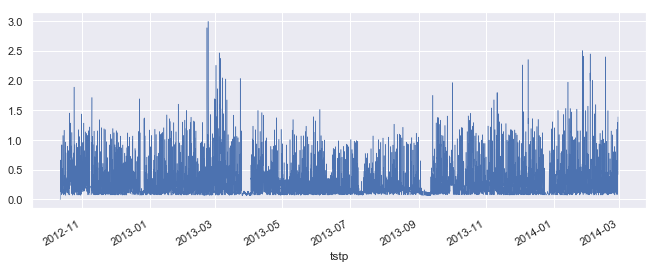

In [8]:
df2['energy(kWh/hh)'].plot(linewidth=0.5)

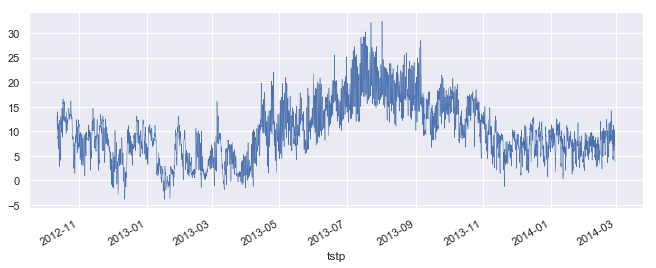

In [9]:
df2['temperature'].plot(linewidth=0.5)

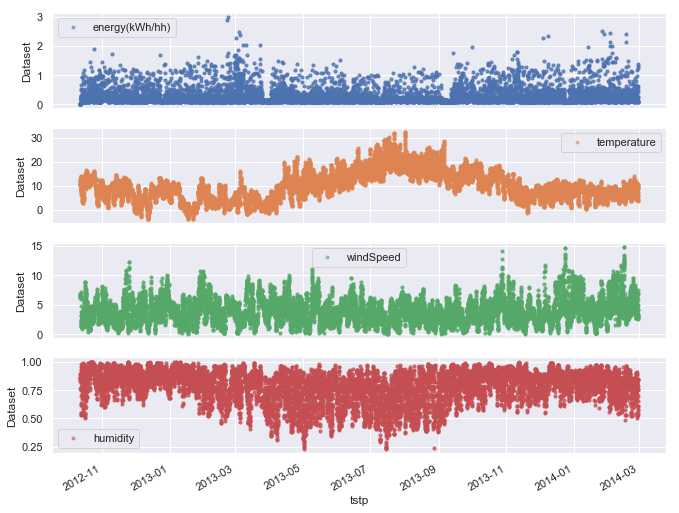

In [10]:
#Relación entre las distintas variables del dataset
cols_plot = ['energy(kWh/hh)', 'temperature', 'windSpeed', 'humidity']
axes = df2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Dataset')

Text(0, 0.5, 'Daily Consumption (kWh/hh)')

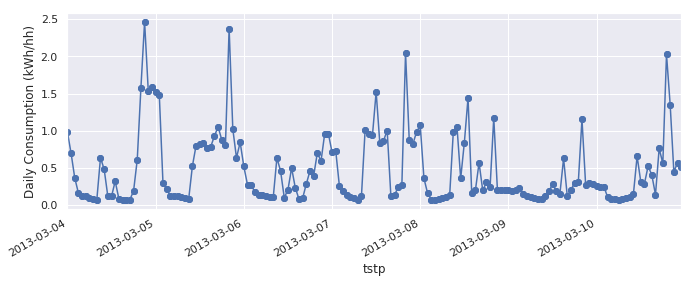

In [39]:
#Comportamiento del consumo energético de una casa durante una semana
ax = df2.loc['2013-03-04':'2013-03-10', 'energy(kWh/hh)'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (kWh/hh)')

Text(0, 0.5, 'Daily Consumption (kWh/hh)')

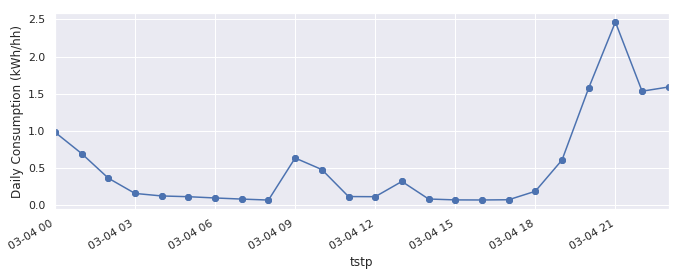

In [40]:
#Comportamiento del consumo energético de la casa seleccionada durante un lunes
ax = df2.loc['2013-03-04', 'energy(kWh/hh)'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (kWh/hh)')

Text(0, 0.5, 'Daily Consumption (kWh/hh)')

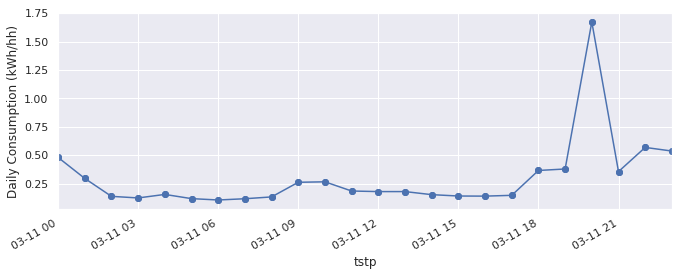

In [42]:
#Comportamiento del consumo energético de la casa seleccionada durante el proximo lunes
ax = df2.loc['2013-03-11', 'energy(kWh/hh)'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (kWh/hh)')

In [11]:
df3=df2.copy()

In [12]:
df3.head()

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-12 01:00:00,0.0,13.09,6.77,0.89
2012-10-12 02:00:00,0.0,12.54,6.46,0.86
2012-10-12 03:00:00,0.0,11.94,6.37,0.84
2012-10-12 04:00:00,0.0,11.47,6.63,0.86
2012-10-12 05:00:00,0.0,10.87,6.55,0.86


In [13]:
# Add columns with year, month, and weekday name

df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3['Weekday Name'] = df3.index.weekday_name

In [14]:
df3.head()

,energy(kWh/hh),temperature,windSpeed,humidity,Year,Month,Weekday Name
tstp,,,,,,,
2012-10-12 01:00:00,0.0,13.09,6.77,0.89,2012,10,Friday
2012-10-12 02:00:00,0.0,12.54,6.46,0.86,2012,10,Friday
2012-10-12 03:00:00,0.0,11.94,6.37,0.84,2012,10,Friday
2012-10-12 04:00:00,0.0,11.47,6.63,0.86,2012,10,Friday
2012-10-12 05:00:00,0.0,10.87,6.55,0.86,2012,10,Friday


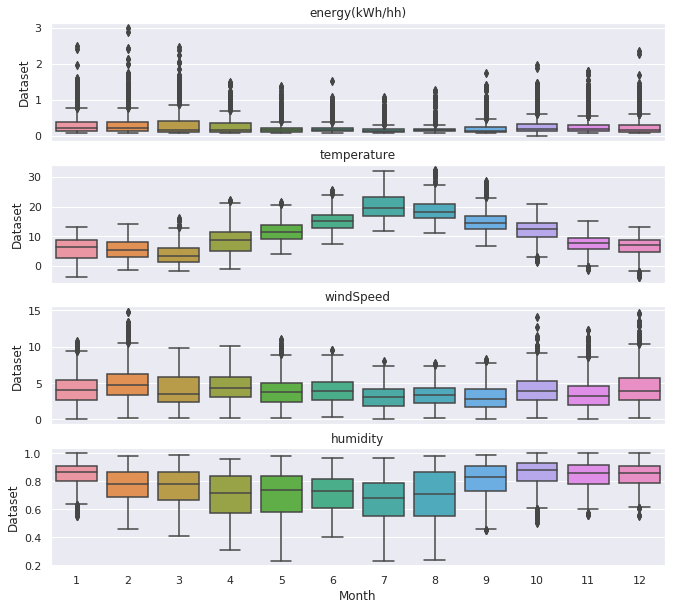

In [48]:
#Comportamiento de las variables del dataset dado los meses
fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['energy(kWh/hh)', 'temperature', 'windSpeed', 'humidity'], axes):
    sns.boxplot(data=df3, x='Month', y=name, ax=ax)
    ax.set_ylabel('Dataset')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
     ax.set_xlabel('')

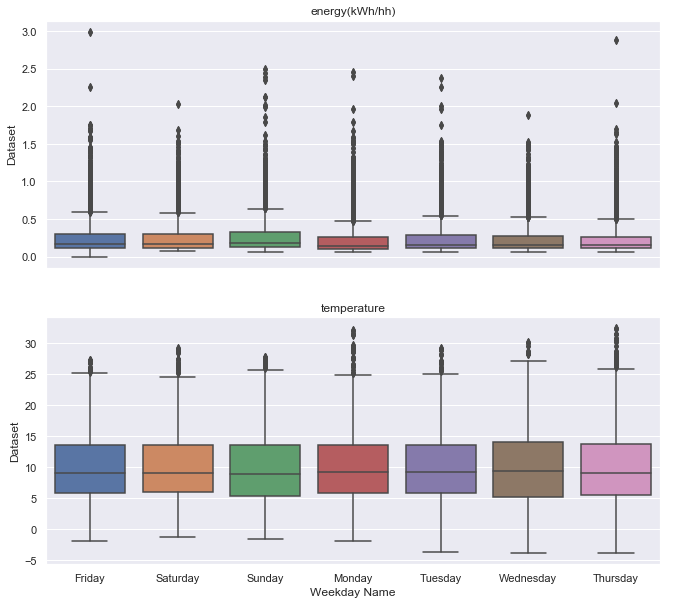

In [20]:
#Comportamiento de las variables del dataset dado los dias de la semana
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['energy(kWh/hh)', 'temperature'], axes):
    sns.boxplot(data=df3, x='Weekday Name', y=name, ax=ax)
    ax.set_ylabel('Dataset')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
     ax.set_xlabel('')

In [0]:
#LSTM Multivariable Consumo Energético de una casa dado los datos de clima

In [0]:
df2 = pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/casa2.csv', parse_dates=['tstp'], index_col="tstp")

In [57]:
df2[22:27]

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-13 00:00:00,0.263,8.78,2.28,0.84
2012-10-13 01:00:00,0.275,8.27,1.81,0.87
2012-10-13 02:00:00,0.211,7.87,1.95,0.89
2012-10-13 03:00:00,0.161,7.89,1.83,0.93
2012-10-13 04:00:00,0.167,7.74,1.38,0.90


In [58]:
len(df2)

24136

In [59]:
''' Dividiendo el dataset en training y test '''
dataset = df2.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

16895 7241


In [60]:
train[0]

array([ 0.  , 13.09,  6.77,  0.89])

In [0]:
'''Funcion para crear tramas de tiempo con look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [0]:
''' Creando tramas de tiempo con look backs '''
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

16875
7221


In [0]:
trainX.shape

(16875, 20, 4)

In [0]:
''' Re-shaping de los datos según los requisitos del modelo '''
trainX = np.reshape(trainX, (trainX.shape[0], 20, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 20, testX.shape[2]))

In [0]:
''' Ajuste de los datos en el modelo LSTM Deep Learning '''
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=True)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               42000     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
''' Haciendo la predicción de los datos '''
yhat = model.predict(testX)
yhat[0:5]

array([[0.11342725],
       [0.09374037],
       [0.09891025],
       [0.09841844],
       [0.09084938]], dtype=float32)

In [0]:
yhat1= yhat[:,0]

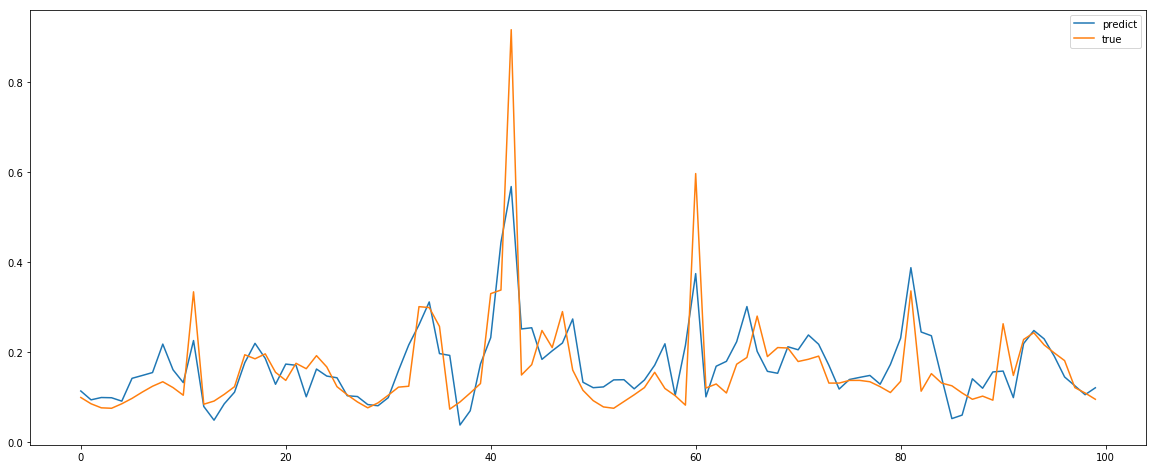

In [0]:
''' Plotting las primeras 100 entradas de la predicción '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat1[0:100], label='predict')
pyplot.plot(testY[0:100], label='true')
pyplot.legend()
pyplot.show()

In [0]:
print("Mean squared error: %.3f" % mean_squared_error(testY, yhat1))

Mean squared error: 0.007


In [0]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, yhat1)))

Root mean squared error: 0.082


In [0]:
#El coeficiente de determinación es una medida estadística de qué tan bien las predicciones de regresión se aproximan a los puntos de datos reales
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))

Variance : 0.890


In [0]:
#Probando con solo datos de clima y haciendo una predicción de consumo energético

In [0]:
df2.head()

,energy(kWh/hh),temperature,windSpeed,humidity
tstp,,,,
2012-10-12 01:00:00,0.0,13.09,6.77,0.89
2012-10-12 02:00:00,0.0,12.54,6.46,0.86
2012-10-12 03:00:00,0.0,11.94,6.37,0.84
2012-10-12 04:00:00,0.0,11.47,6.63,0.86
2012-10-12 05:00:00,0.0,10.87,6.55,0.86


In [0]:
df2.dtypes

energy(kWh/hh)    float64
temperature       float64
windSpeed         float64
humidity          float64
dtype: object

In [0]:
''' Dividiendo el dataset en training y test '''
dataset = df2.values
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

16895 7241


In [0]:
'''Helper to create time frames with look backs '''
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 1:4]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [0]:
''' Creando tramas de tiempo con look backs '''
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

16875
7221


In [0]:
trainX[0]

array([[13.09,  6.77,  0.89],
       [12.54,  6.46,  0.86],
       [11.94,  6.37,  0.84],
       [11.47,  6.63,  0.86],
       [10.87,  6.55,  0.86],
       [10.37,  6.11,  0.89],
       [10.39,  6.71,  0.87],
       [10.29,  6.59,  0.83],
       [10.94,  6.75,  0.76],
       [12.32,  7.15,  0.64],
       [13.86,  6.92,  0.53],
       [13.99,  7.  ,  0.53],
       [13.52,  6.63,  0.55],
       [12.69,  6.5 ,  0.62],
       [12.46,  5.98,  0.55],
       [11.31,  4.71,  0.62],
       [10.39,  3.7 ,  0.7 ],
       [ 9.38,  3.2 ,  0.75],
       [ 8.93,  3.12,  0.78],
       [ 8.93,  2.15,  0.78]])

In [0]:
trainY[0]

0.27

In [0]:
''' Re-shaping de los datos según los requisitos del modelo '''
trainX = np.reshape(trainX, (trainX.shape[0], 20, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 20, testX.shape[2]))

W0705 17:27:46.903688 140107020904320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 17:27:46.982258 140107020904320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 17:27:47.003438 140107020904320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 17:27:47.290713 140107020904320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0705 17:27:47.515556 140107020904320 deprecation.py:323

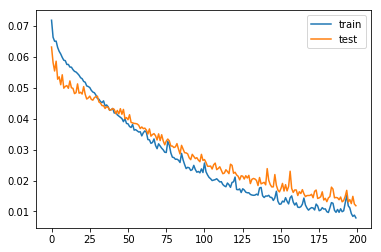

In [0]:
''' Ajuste de los datos en el modelo LSTM Deep Learning '''
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


In [0]:
''' Haciendo la predicción de los datos '''
yhat = model.predict(testX)
yhat[0:5]

array([[0.0115067 ],
       [0.0664138 ],
       [0.01942026],
       [0.04446337],
       [0.08021378]], dtype=float32)

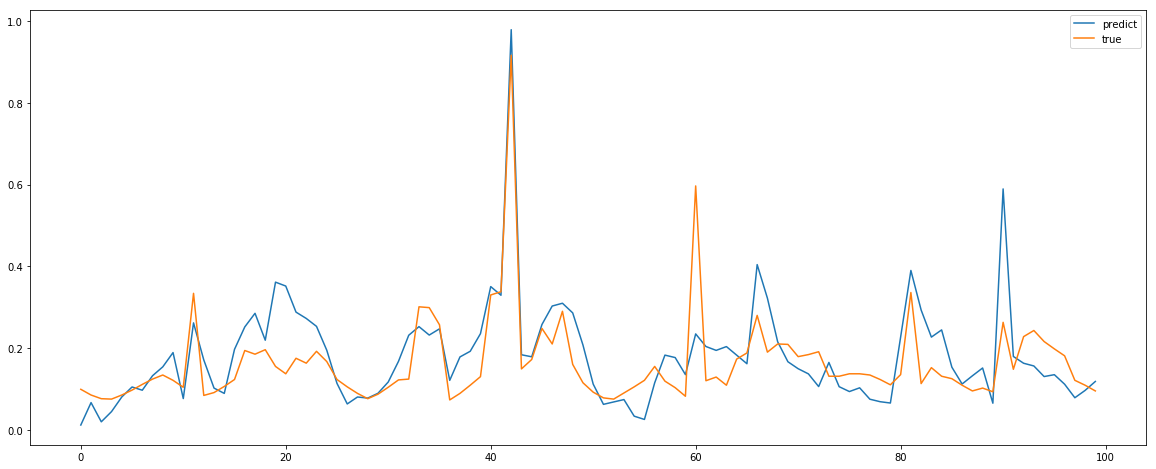

In [0]:
''' Plotting las primeras 100 entradas de la predicción '''
pyplot.figure(figsize=(20,8))
pyplot.plot(yhat[0:100], label='predict')
pyplot.plot(testY[0:100], label='true')
pyplot.legend()
pyplot.show()

In [0]:
print("Mean squared error: %.3f" % mean_squared_error(testY, yhat))

Mean squared error: 0.012


In [0]:
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(testY, yhat)))

Root mean squared error: 0.109


In [0]:
from sklearn.metrics import mean_squared_error, r2_score
print('Variance : %.3f' % r2_score(testY, yhat))

Variance : 0.808
